In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def show_images(images, size=(16, 8), mode='grayscale', dpi=150, image_type=None, grid=None, title=(None,None), fig_suptitle=None): 
        if not isinstance(images, tuple) and not isinstance(images, list):
            images = [images]
            title = [title]
            grid = (1, 1)
        if isinstance(mode, tuple) or isinstance(mode, list):
            change_mode = True
        else:
            current_mode = mode
            change_mode = False
        
        if isinstance(image_type, tuple) or isinstance(image_type, list):
            change_mode_type = True
        else:
            current_mode_type = image_type
            change_mode_type = False
        
        if not grid:
            grid = []
            grid.append(math.ceil(len(images) / 2))
            grid.append(3)
            
        fig=plt.figure(figsize=size, dpi=dpi)
        for i, img in enumerate(images):
            fig.add_subplot(grid[0], grid[1], i+1)

            if change_mode:
                current_mode = mode[i]
            if change_mode_type:
                current_mode_type = image_type[i]

            if current_mode=='grayscale':
                if current_mode_type=='spectrum':
                    plt.imshow(np.abs(img)**(0.1), cmap='gray')
                else:
                    plt.imshow(img, cmap='gray')
            else:
                if current_mode_type=='spectrum':
                    plt.imshow(np.abs(img)**(0.1))
                else:
                    plt.imshow(img)
                    
            if title[i] is not None:
                plt.title(title[i])
            plt.axis('off')
        fig.suptitle(fig_suptitle, fontsize=16)
        plt.show()

In [3]:
def normalize_image(np_img, mul_const=1.0):
    return (mul_const * (np_img-np_img.min()) / (np_img.max() - np_img.min()))

In [4]:
def cut_img_values(img):
    img_copy = img
    img_copy[img_copy < 0] = 0
    img_copy[img_copy > 255] = 255
    return img_copy

In [135]:
def process_skeleton_img(img):
    # (a) Исходное изображение
    # (б) Применение оператора лапласиана к изображению
    # ddepth: S - signed, U - unsigned 
    laplassian_img_cut = cut_img_values(cv2.Laplacian(img, ddepth=cv2.CV_16U, ksize=3))
    
    laplassian_img = normalize_image(cv2.Laplacian(img, ddepth=cv2.CV_16U, ksize=3), 255.0).astype("int")
    laplassian_img = (255 * np.power(laplassian_img / 255, 0.7)).astype("int")
    
    # (в) Повышение резкости сложением изображений (а) и (б)
    laplassian_img_add = normalize_image(img + laplassian_img_cut, 255.0).astype("int")

    # (г) Применение градиентного оператора Собела к изображению (а)
    sobel_via_x = cv2.Sobel(img, ddepth=cv2.CV_16S, dx=1, dy=0)
    sobel_via_y = cv2.Sobel(img, ddepth=cv2.CV_16S, dx=0, dy=1)
    sobel = np.absolute(sobel_via_x) + np.absolute(sobel_via_y)
    sobel_img = cut_img_values(img + sobel)
    
    # (д) Изображение (г), сглаженное усредняющим фильтром по окрестности 5×5.
    sobel_blur = cv2.blur(sobel_img, (5, 5))
    
    # (е) Изображение-маска, полученное перемножением изображений (в) и (д)
    laplassian_blur_sobel_mask = normalize_image(
        cv2.multiply(laplassian_img_add, sobel_blur, dtype=cv2.CV_16S), 255.0).astype(int)
    
    # (ж) Изображение с повышенной резкостью, полученное сложением изображений (а) и (е).
    orig_laplassian_blur_sobel_mask = cut_img_values(img + laplassian_blur_sobel_mask)
    
    # (з) Конечный результат, полученный из изображения (ж) градационной коррекцией по степенному закону
    final_res = (255 * np.power(orig_laplassian_blur_sobel_mask / 255, 0.5)).astype("int")
    
    return (
        img,
        laplassian_img,
        laplassian_img_add,
        sobel_img,
        sobel_blur,
        laplassian_blur_sobel_mask,
        orig_laplassian_blur_sobel_mask,
        final_res
    )

In [136]:
img = cv2.imread("skeleton_orig.jpg")

images = process_skeleton_img(img)

titles = (
    "A. Оригинальнал",
    "Б. Оператор лапласиана к (А)",
    "В. Сложение (А) и (Б)",
    "Г. Оператор Собела к (А)",
    "Д. Сглаживающеий фильтр к (Г)",
    "E. Перемножение (В) и (Д)",
    "Ж. Сложение (А) и (Е)",
    "З. Градационная коррекция (Ж)"
)

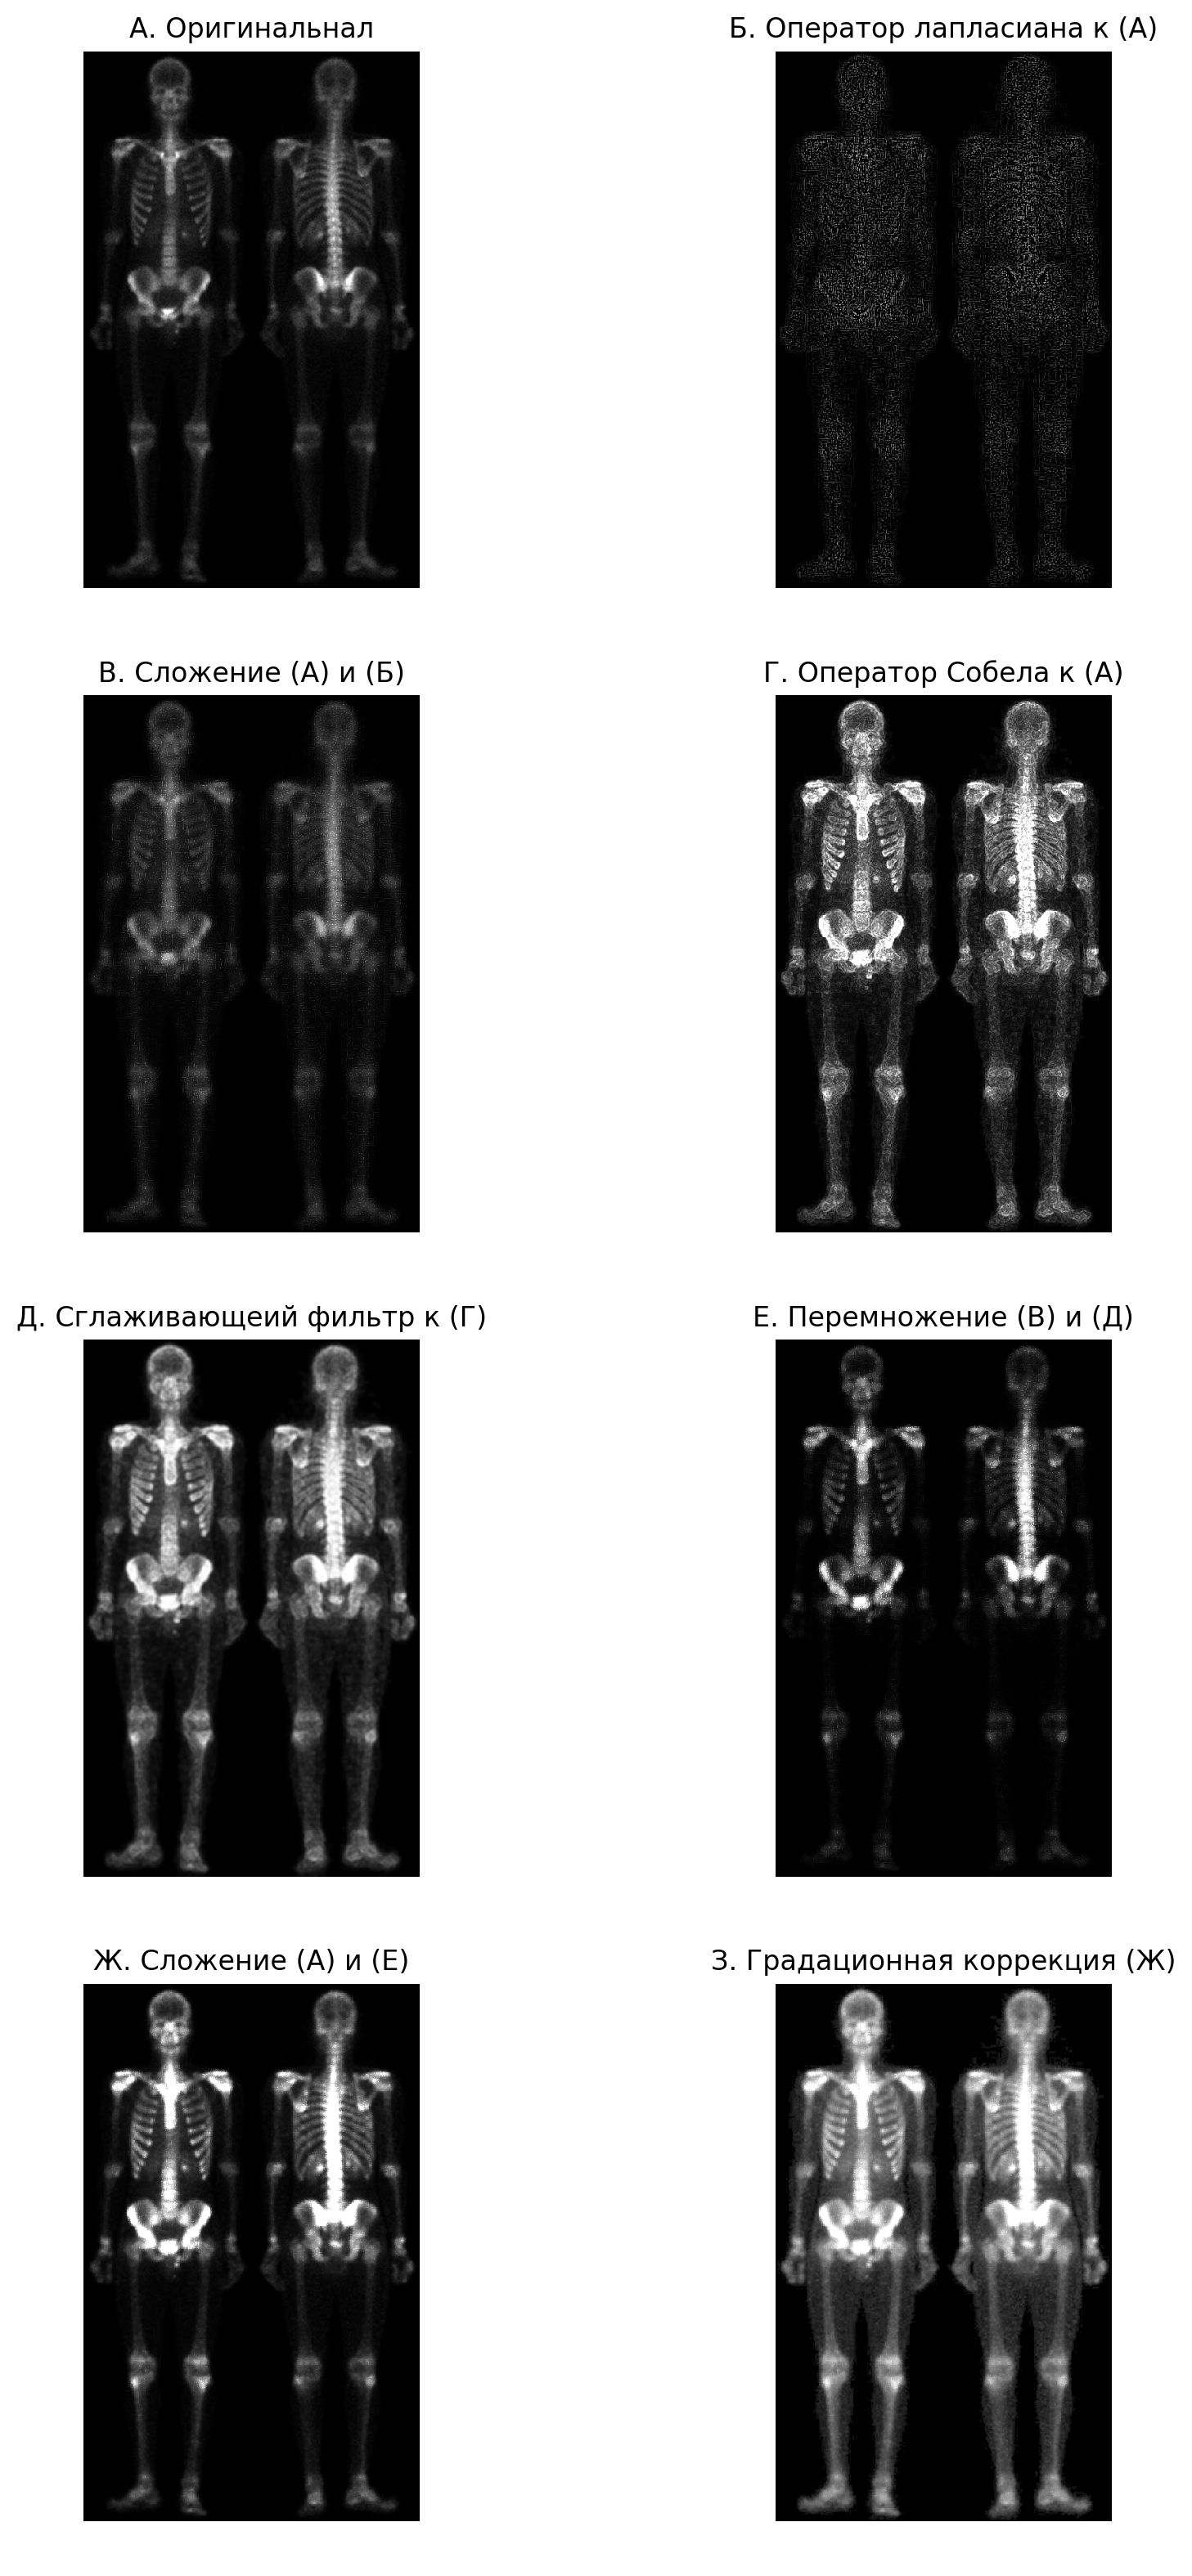

In [137]:
show_images(images, grid=(4,2), title=titles, size=(10,20), dpi=200)